# EfficientNet V2 usando PyTorch Lightning


## Instalar e importar bibliotecas


In [16]:
import os
from pathlib import Path

In [17]:
def is_remote_vscode():
    """Detect if running in VSCode remote container/SSH environment.

    Uses DMI Product information to distinguish between VSCode Remote and Google Colab.
    Google Colab runs on "Google Compute Engine" VMs.
    """
    try:
        if os.path.exists("/sys/class/dmi/id/product_name"):
            with open("/sys/class/dmi/id/product_name", "r") as f:
                product = f.read().strip()
                print("DMI:", product)
                # Google Colab runs on Google Compute Engine
                if "Google" in product or "Compute Engine" in product:
                    return False  # This is Google Colab
        # If not Google Compute Engine, assume VSCode Remote/Local
        return True
    except:
        # If we can't read DMI, assume local/non-Colab
        return True


# Detect environment and set optimal configurations
IS_REMOTE = is_remote_vscode()
print(f"Environment detected: {'VSCode Remote' if IS_REMOTE else 'Google Colab'}")

# Performance-optimized settings based on environment
if IS_REMOTE:
    ENABLE_PROGRESS_BAR = False  # Disable progress bar updates over network
else:
    ENABLE_PROGRESS_BAR = True
print(f"Progress bar enabled: {ENABLE_PROGRESS_BAR}")

DMI: DGXH200
Environment detected: VSCode Remote
Progress bar enabled: False


In [18]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torchmetrics

from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar

from settings import config # Custom package in /src to store configuration settings

## Definición de hiperparámetros de la red

In [19]:
BATCH_SIZE = 32
NUM_EPOCHS = 100 # Podemos usar un número alto porque tenemos EarlyStopping después
LEARNING_RATE = 0.001
NUM_WORKERS = 100
CLASES = 1 # En este caso es 1 porque es un problema de clasificación binaria
DATA_DIR = config.data_dir
LOGS_DIR = config.logs_dir

print(f"Data directory: {DATA_DIR}")
print(f"Logs directory: {LOGS_DIR}")

Data directory: /home/docampor/usfq-mmia/data
Logs directory: /home/docampor/usfq-mmia/logs


## Preparación de la base de datos: PCam

### PCam contiene 327k RGB imágenes de 96x96x3 pixeles distribuidas en 2 clases indicando la presencia de tejido metastásico (1) o tejido sano (0). Las imágenes se han dividido en dos grupos:

*   Grupo de entrenamiento: 262K imágenes
*   Grupo de evaluación: 32k imágenes

In [20]:
train_dataset = torchvision.datasets.PCAM(
    root=DATA_DIR, split="train", transform=transforms.ToTensor(), download=False
)

test_dataset = torchvision.datasets.PCAM(
    root=DATA_DIR, split="test", transform=transforms.ToTensor(), download=False
)

Revisamos la distribución de clases en el grupo de entrenamiento para verificar que no hay un desbalance significativo:

In [42]:
# Count the class distribution in the training dataset
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)

class_counts = Counter(train_labels)
print(f"Clase 0 (Tejido sano): {class_counts[0]} muestras")
print(f"Clase 1 (Tejido metastásico): {class_counts[1]} muestras")

Clase 0 (Tejido sano): 131072 muestras
Clase 1 (Tejido metastásico): 131072 muestras


Notemos que el dataset está exactamente balanceado, por lo que el accuracy es una métrica adecuada para evaluar el desempeño del modelo, y no necesitamos tomar medidas adicionales para lidiar con un desbalance de clases.

In [22]:
# Definimos dataloaders para los datasets
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=False,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    drop_last=False,
    shuffle=False,
)

In [23]:
print("Número de muestras de entrenamiento:", len(train_dataset))
print("Número de muestras de evaluación:", len(test_dataset))

Número de muestras de entrenamiento: 262144
Número de muestras de evaluación: 32768


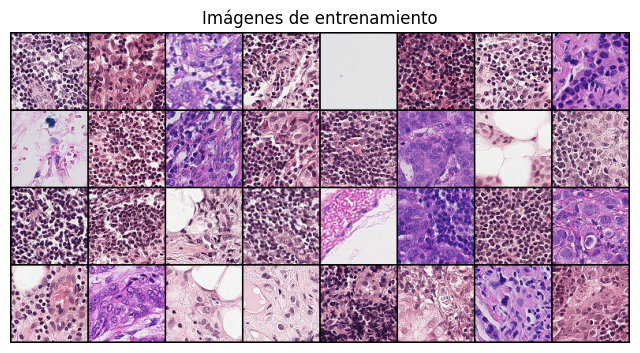

In [24]:
# Visualización de imágenes
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imágenes de entrenamiento")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(images[:64], padding=2, normalize=True), (1, 2, 0)
    )
)
plt.show()

Notemos que los labels del batch tienen dos características que tendremos que manejar:
- Son enteros, así que tendremos que convertirlos a float eventualmente
- Tienen un shape (batch_size,) en lugar de (batch_size, 1), que es la salida de nuestra red. Esto se puede solucionar fácilmente con un reshape, unsqueeze o squeeze.

In [25]:
labels

tensor([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1])

In [26]:
# Dimensión de cada imagen
print("Dimensión de entrada:", images.shape) # (batch_size, channels_in, W, H)

Dimensión de entrada: torch.Size([32, 3, 96, 96])


### Definición de PCam DataModule para Lightning

La [documentación de Efficient Net](https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.efficientnet_v2_s) indica que el tamaño de entrada esperado es de 384x384, pero ya que las imágenes de nuestro dataset son de 96x96, omitimos los pasos de resize o random cropping. Esto no debería causar problemas, considerando que la docu indica que el tamaño mínimo del input es 33x33.

Además, aplicamos las siguientes transformaciones a las imágenes de entrenamiento para aumentar la variabilidad de los datos y ayudar a que el modelo generalice mejor:
- Random horizontal flip
- Random vertical flip
- Random rotation de hasta 20 grados
- Color jitter con un factor de 0.2 para brillo, contraste y saturación, y 0.05 para hue

In [ ]:
class PCam_DataModule(pl.LightningDataModule):
    def __init__(self, data_path: str | Path = "./"):
        super().__init__()
        self.data_path = data_path
        self.train_transform = torchvision.transforms.Compose(
            [
                # torchvision.transforms.Resize((256, 256)),
                # torchvision.transforms.RandomCrop((224, 224)),
                torchvision.transforms.RandomHorizontalFlip(p=0.5),
                torchvision.transforms.RandomVerticalFlip(p=0.5),
                torchvision.transforms.RandomRotation(degrees=20),
                torchvision.transforms.ColorJitter(
                    brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05
                ),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
                ),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                # torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
                ),
            ]
        )

    def prepare_data(
        self,
    ):
        # Método prepare_data es usado para pasos que van a ser ejecutados solo una vez, como descargar el dataset y definir las transformaciones

        # datasets.CIFAR10(root=self.data_path, download=True)
        torchvision.datasets.PCAM(
            root=DATA_DIR,
            split="train",
            download=True,
        )
        
        torchvision.datasets.PCAM(
            root=DATA_DIR,
            split="test",
            download=True,
        )

        return

    def setup(self, stage=None):  # cargamos el dataset
        train = datasets.PCAM(
            root=self.data_path,
            split="train",
            transform=self.train_transform,
            download=False,
        )

        self.test = datasets.PCAM(
            root=self.data_path,
            split="test",
            transform=self.test_transform,
            download=False,
        )

        # Dividir el grupo de entrenamiento original en entrenamiento y validación
        train_len = len(train)
        train_size = int(train_len * 0.9)
        valid_size = train_len - train_size
        self.train, self.valid = random_split(train, lengths=[train_size, valid_size])

        print("Muestras de entrenamiento:", len(self.train))
        print("Muestras de validación:", len(self.valid))
        print("Muestras de evaluación:", len(self.test))

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS,
        )

        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )

        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )

        return test_loader

In [28]:
# Inicizalización de DataModule
torch.manual_seed(47)  # especificamos un random seed para reproducibilidad de inicializaciones aleatorias
data_module = PCam_DataModule(data_path=DATA_DIR)

## Importar la arquitectura EfficientNet_V2_S

Razones para elegir EfficientNetV2 para el dataset PCam:
- EfficientNetV2 fue diseñado para entrenar más rápido y con mejor eficiencia de parámetros que familias anteriores. Esto es útil en PCam porque, aunque no es tan grande como ImageNet, sí es lo suficientemente grande (327k imágenes de entrenamiento) como para que el costo de entrenamiento importe. En particular, hacer fine-tunning solamente sobre 2 de las 7 capas de EfficientNetV2-S ya tomó más de 70 minutos, por lo que la velocidad de entrenamiento es un factor importante a considerar. Por supuesto, esto pasa porque estamos entrenando en un notebook, si fuera un script todo sería 8 veces o más rápido.
- El paper destaca que los modelos pueden ser hasta 6.8x más pequeños manteniendo buen desempeño; para PCam (binario, 96×96) esto sugiere que podemos lograr buen accuracy sin un modelo muy grande y pesado, reduciendo la posibilidad de overfitting y consumo de recursos.
- Aprovechamos el preentrenamiento en ImageNet, que es un dataset de imágenes naturales, para que el modelo aprenda features visuales generales (bordes, texturas, formas) que son útiles incluso en histopatología. Luego, con fine-tuning, el modelo puede especializarse en las características específicas del dominio médico de PCam.


In [29]:
pytorch_model = torchvision.models.efficientnet_v2_s(
    weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
)

Ahora modificamos el numero de clases de salida en EfficientNet_V2_S

In [30]:
pytorch_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [31]:
# Example input tensor with shape [32, 3, 96, 96]
input_tensor = torch.randn(32, 3, 96, 96)
# Forward pass through the feature extractor (excluding classifier)
features_ex = pytorch_model.features(input_tensor)  # Shape: [32, 1280, 1, 1]
print("Salida del bloque features: ", features_ex.shape)
# Apply global average pooling, reducing the spatial dimensions to 1x1
global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
pooled_features = global_avg_pool(features_ex)  # Shape: [32, 1280, 1, 1]
print("Salida del bloque features after avg pooling: ", pooled_features.shape)
# Flatten the tensor
flattened_features = torch.flatten(pooled_features, 1)  # Shape: [32, 1280]
print("Salida 1D: ", flattened_features.shape)

# where is the avg pooling in the model?
import inspect

print(inspect.getsource(pytorch_model.forward))
print(inspect.getsource(pytorch_model._forward_impl))

Salida del bloque features:  torch.Size([32, 1280, 3, 3])
Salida del bloque features after avg pooling:  torch.Size([32, 1280, 1, 1])
Salida 1D:  torch.Size([32, 1280])
    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x



In [32]:
# Sobre escribimos el clasificador de la red, el cual es la ultima capa [-1]
pytorch_model.classifier[-1] = torch.nn.Linear(
    in_features=1280,  # Vector de caracteristicas entregado por EfficientNet_V2_S
    out_features=CLASES,
)  # Numero de clases para PCAM

Seleccionamos el número de capas que van a re-entrenarse

In [33]:
pytorch_model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): FusedMBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (stochastic_de

In [ ]:
# Definimos cuántos de los primeros bloques (módulos) del extractor de características queremos congelar.
# Por ejemplo, congelar los primeros 10 bloques (índices 0 a 9).
# Puedes ajustar este número para experimentar con diferentes estrategias de fine-tuning.
num_blocks_to_freeze = 5 #puede tomar valores de 0 a 7 (ver pytorch_model.features)

# Iterar sobre los módulos (bloques) del extractor de características.
for i, child in enumerate(pytorch_model.features.children()):
    if i < num_blocks_to_freeze:
        # Congelar todos los parámetros de este bloque
        for param in child.parameters():
            param.requires_grad = False
    else:
        # Descongelar todos los parámetros de este bloque
        for param in child.parameters():
            param.requires_grad = True

# Asegurarse de que el clasificador siempre se entrene
for param in pytorch_model.classifier.parameters():
    param.requires_grad = True

print(f"Se han congelado los parámetros de los primeros {num_blocks_to_freeze} bloques del extractor de características.")
print("Los parámetros de los bloques restantes (y el clasificador) se entrenarán.")

# Imprimir el estado de requires_grad para todos los parámetros del modelo
print("\nEstado de requires_grad para cada parámetro del modelo:")
for name, param in pytorch_model.named_parameters():
    print(f"  '{name}': {param.requires_grad}")

Se han congelado los parámetros de los primeros 5 bloques del extractor de características.
Los parámetros de los bloques restantes (y el clasificador) se entrenarán.

Estado de requires_grad para cada parámetro del modelo:
  'features.0.0.weight': False
  'features.0.1.weight': False
  'features.0.1.bias': False
  'features.1.0.block.0.0.weight': False
  'features.1.0.block.0.1.weight': False
  'features.1.0.block.0.1.bias': False
  'features.1.1.block.0.0.weight': False
  'features.1.1.block.0.1.weight': False
  'features.1.1.block.0.1.bias': False
  'features.2.0.block.0.0.weight': False
  'features.2.0.block.0.1.weight': False
  'features.2.0.block.0.1.bias': False
  'features.2.0.block.1.0.weight': False
  'features.2.0.block.1.1.weight': False
  'features.2.0.block.1.1.bias': False
  'features.2.1.block.0.0.weight': False
  'features.2.1.block.0.1.weight': False
  'features.2.1.block.0.1.bias': False
  'features.2.1.block.1.0.weight': False
  'features.2.1.block.1.1.weight': Fals

## Definición del Módulo Lightning

In [36]:
class Lightning_CNN(pl.LightningModule):
    def __init__(self, model, learning_rate, classes):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.classes = classes

        # Guardar hiperparametros en directorio de logs
        # Ignora los pesos del modelo
        self.save_hyperparameters(ignore=["model"])

        # Definición de métricas para cada grupo de datos
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.valid_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # Pasos del proceso forward comunes entre train, val, test
    def _shared_step(self, batch):
        features, true_labels = batch
        true_labels = true_labels.float()
        logits = self(features).squeeze()  # Eliminar dimensiones extra si es necesario
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            logits, true_labels
        )
        probs = torch.nn.functional.sigmoid(logits)
        predicted_labels = (
            probs > 0.5
        ).float()  # Convertir probabilidades a etiquetas binarias

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)

        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log(
            "valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True
        )

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        return optimizer

## Entrenamiento del modelo

In [37]:
class CustomLoggingCallback(pl.Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        self.epoch_start_time = time.time()

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_duration = time.time() - self.epoch_start_time
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics.get("train_loss")
        valid_loss = trainer.callback_metrics.get("valid_loss")

        output_str = f"Epoch {epoch}: "
        if train_loss is not None:
            output_str += f"Train Loss: {train_loss:.4f}, "
        if valid_loss is not None:
            output_str += f"Valid Loss: {valid_loss:.4f}, "
        output_str += f"Time per Epoch: {epoch_duration:.2f} seconds"
        print(output_str)


custom_logger_callback = CustomLoggingCallback()

In [ ]:
# Inicialización del modulo lightning

lightning_model = Lightning_CNN(
    pytorch_model, learning_rate=LEARNING_RATE, classes=CLASES
)

# Guardamos el mejor modelo monitoreado en la acc de validación.
callback_check = ModelCheckpoint(
    save_top_k=1, mode="max", monitor="valid_acc"
)

# Detiene el entrenamiento si la acc de validación no mejora por 5 épocas
# Obviamente, buscamos el accuracy máximo en validación, no en entrenamiento, 
# porque el objetivo es generalizar a datos no vistos
early_stopping_callback = EarlyStopping(
    monitor="valid_acc", patience=5, mode="max"
)

callback_tqdm = RichProgressBar(leave=True)

logger = CSVLogger(save_dir=LOGS_DIR, name="efficientnet_v2_s_finetune")

In [39]:
#  Inicia entrenamiento
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=[callback_check, custom_logger_callback, early_stopping_callback],
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100,
    enable_progress_bar=ENABLE_PROGRESS_BAR,
)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
You are using a CUDA device ('NVIDIA H200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Muestras de entrenamiento: 235929
Muestras de validación: 26215
Muestras de evaluación: 32768


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type           ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ EfficientNet   │ 20.2 M │ train │     0 │
│ 1 │ train_acc │ BinaryAccuracy │      0 │ train │     0 │
│ 2 │ valid_acc │ BinaryAccuracy │      0 │ train │     0 │
│ 3 │ test_acc  │ BinaryAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────┴────────┴───────┴───────┘

Trainable params: 18.4 M                                                                                           
Non-trainable params: 1.8 M                                                                                        
Total params: 20.2 M                                                                                               
Total estimated model params size (MB): 80                                                                         
Modules in train mode: 717                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/home/docampor/usfq-mmia/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


Epoch 0: Train Loss: 0.1865, Valid Loss: 0.1845, Time per Epoch: 229.30 seconds
Epoch 1: Train Loss: 0.1131, Valid Loss: 0.1999, Time per Epoch: 206.84 seconds
Epoch 2: Train Loss: 0.2588, Valid Loss: 0.1563, Time per Epoch: 234.27 seconds
Epoch 3: Train Loss: 0.1182, Valid Loss: 0.3397, Time per Epoch: 208.14 seconds
Epoch 4: Train Loss: 0.0446, Valid Loss: 0.1482, Time per Epoch: 224.83 seconds
Epoch 5: Train Loss: 0.4565, Valid Loss: 0.2458, Time per Epoch: 218.92 seconds
Epoch 6: Train Loss: 0.1849, Valid Loss: 0.4004, Time per Epoch: 233.16 seconds
Epoch 7: Train Loss: 0.0963, Valid Loss: 0.1509, Time per Epoch: 220.10 seconds
Epoch 8: Train Loss: 0.0670, Valid Loss: 0.1304, Time per Epoch: 229.15 seconds
Epoch 9: Train Loss: 0.0705, Valid Loss: 0.1803, Time per Epoch: 218.07 seconds
Epoch 10: Train Loss: 0.0988, Valid Loss: 0.1399, Time per Epoch: 235.81 seconds
Epoch 11: Train Loss: 0.4993, Valid Loss: 0.1810, Time per Epoch: 217.54 seconds
Epoch 12: Train Loss: 0.1113, Valid Lo

El entrenamiento duró solamente 20 épocas y terminó en 78 minutos, por lo que el Early Stopping fue muy efectivo en reducir el tiempo de entrenamiento, evitando que el modelo se sobreentrene y ahorrando recursos computacionales.

## Graficamos las curvas de aprendizaje del modelo

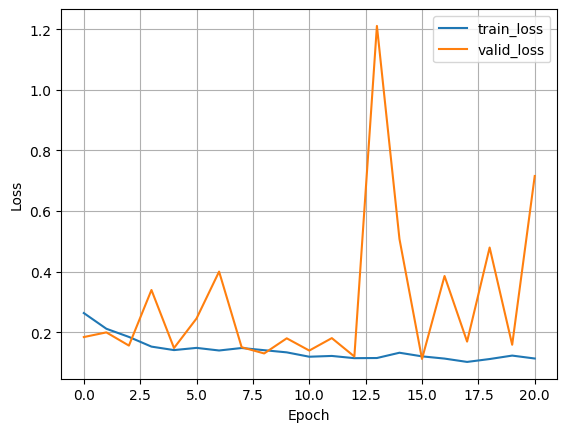

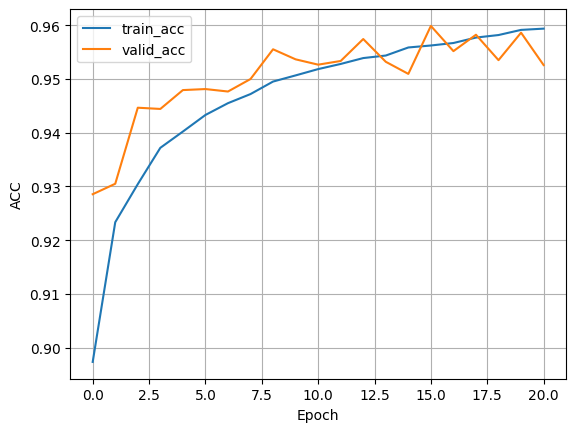

In [40]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [41]:
trainer.test(
    model=lightning_model, datamodule=data_module, ckpt_path="best"
)  # cargamos el mejor checkpoint del modelo

Restoring states from the checkpoint path at /home/docampor/usfq-mmia/logs/efficientnet_v2_s_finetune/version_6/checkpoints/epoch=15-step=117952.ckpt


Muestras de entrenamiento: 235929
Muestras de validación: 26215
Muestras de evaluación: 32768


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loaded model weights from the checkpoint at /home/docampor/usfq-mmia/logs/efficientnet_v2_s_finetune/version_6/checkpoints/epoch=15-step=117952.ckpt
/home/docampor/usfq-mmia/.venv/lib/python3.13/site-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.83880615234375      │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.83880615234375}]

La curva de aprendizaje en el conjunto de validación es muy extraña. En la de entrenamiento, hay una reducción continua hacia el mínimo tal y como esperaríamos, pero en la de validación hay mucha oscilación en la pérdida y ninguna tendencia clara. Tal vez experimentando con el número de capas congeladas y la paciencia en el early stopping se podrían obtener curvas de aprendizaje más suaves, pero por ahora nos quedamos con este resultado. De todas formas, el modelo obtuvo un accuracy de 0.83 en el grupo de test, lo cual es un resultado bastante bueno considerando que el dataset es difícil y que el modelo se entrenó por poco tiempo.